## Building small NN to better understand backpropagation and DL Fundamentals
follows repo from Andrej Karpathy: https://github.com/karpathy/micrograd 

In [131]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

### 1. Defining the Value class
- entity to handle scalar values and their derivative

In [132]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

Note 1: The function like \__add__() for addition and \__mul__() for multiplication must be specified, because e.g. when adding two Value objects, Python internally calls a.\__add__(b). Without definition of the method, Python does not know how to perform this addition operation for the Value objects. Once we specified these methods, Python internally uses our definition of \__add__() and \__mul__().

Note 2: Regarding the underscores in the parameters. No underscore meant to be a public attribute that has to be provided (e.g. data). One underscore signals a protected attribute which is set internally by the class method (e.g. _op) and hence should never be provided manually by the programmer. 

In [133]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        """Sum over the tuples of x and w and multiply them as input for the neuron."""
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

Explanation of the \__call__ function: Imagine x = [2.0, 3.0] and we initialize a Neuron with n = Neuron(2). When using n(x) python internally uses the \__call__() method.

## Toy Example - Building simple MLP

In [134]:
x = [2.0, 3.0, -2]
# MLP with 3 inputs and 4 layer Neron, 4 layer Neuron and output layer with single Neuron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.37696859689889795, grad=0)

In [ ]:
n = MLP(3, [4, 4, 1])
xs = [                  # input data
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

In [311]:
for k in range (20):
    # Forward Pass --> Prediction with the new weights
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # Backward Pass
    n.zero_grad()
    loss.backward()
    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 2.2802783457403594e-11
1 1.636717768741506e-11
2 1.1747887078034177e-11
3 8.432294793169821e-12
4 6.052459283048734e-12
5 4.344282765234411e-12
6 3.118203512313639e-12
7 2.238159625721092e-12
8 1.606489831970986e-12
9 1.1530957139740322e-12
10 8.276626698003781e-13
11 5.940763466370414e-13
12 4.264149157543216e-13
13 3.060724451059825e-13
14 2.1969414053168905e-13
15 1.5769432119876544e-13
16 1.1319266535775573e-13
17 8.125067925097646e-14
18 5.832365661203505e-14
19 4.18673108926468e-14


In [312]:
ypred

[Value(data=0.9999998592113816, grad=-2.8157723686028646e-07),
 Value(data=-0.9999999695237088, grad=6.095258231475498e-08),
 Value(data=-0.9999999640050502, grad=7.198989959711355e-08),
 Value(data=0.9999998592113816, grad=-2.8157723686028646e-07)]

## Doing a little demo of the Code

In [9]:
%matplotlib


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [ ]:
%pip install scikit-learn

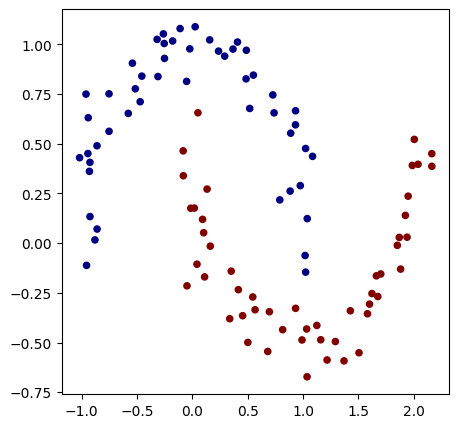

In [21]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [22]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [23]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.2413199670128956, grad=0) 0.61


In [24]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.2413199670128956, accuracy 61.0%
step 1 loss 0.45302190163581246, accuracy 82.0%
step 2 loss 0.610768673340919, accuracy 76.0%
step 3 loss 1.375009994001092, accuracy 66.0%
step 4 loss 0.40080259917059186, accuracy 81.0%
step 5 loss 0.3469194266281308, accuracy 83.0%
step 6 loss 0.31507994363563413, accuracy 86.0%
step 7 loss 0.29662303882037694, accuracy 87.0%
step 8 loss 0.28076156850523387, accuracy 88.0%
step 9 loss 0.27297139577702617, accuracy 86.0%
step 10 loss 0.2663869079448956, accuracy 88.0%
step 11 loss 0.2637003430520597, accuracy 87.0%
step 12 loss 0.2353097881047274, accuracy 90.0%
step 13 loss 0.2297236787618964, accuracy 91.0%
step 14 loss 0.2300597790417845, accuracy 91.0%
step 15 loss 0.22185041728743887, accuracy 92.0%
step 16 loss 0.21507816746520136, accuracy 91.0%
step 17 loss 0.22119754535266764, accuracy 93.0%
step 18 loss 0.23682575123475755, accuracy 90.0%
step 19 loss 0.21327002798457548, accuracy 91.0%
step 20 loss 0.18172559552920933, accurac

There is a learning rate decay implemented in the updating step. The main idea is that in the beginning we want the model to explore the parameter space and make bigger leaps while in the end, it's more reasonable to make smaller steps in the correct direction to arrive at the minimum.

(-1.6721280994088947, 2.0778719005911053)

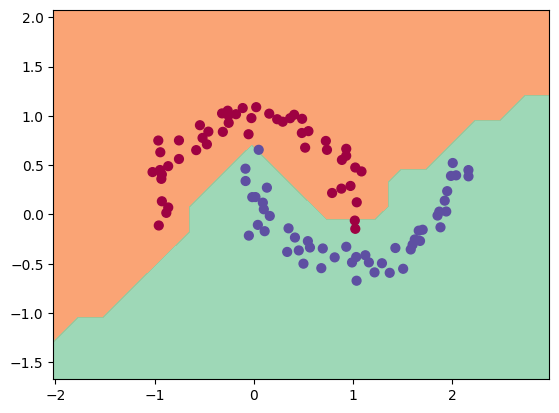

In [25]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())